$
\newcommand{\xv}{\mathbf{x}}
\newcommand{\Xv}{\mathbf{X}}
\newcommand{\yv}{\mathbf{y}}
\newcommand{\Yv}{\mathbf{Y}}
\newcommand{\zv}{\mathbf{z}}
\newcommand{\av}{\mathbf{a}}
\newcommand{\Wv}{\mathbf{W}}
\newcommand{\wv}{\mathbf{w}}
\newcommand{\gv}{\mathbf{g}}
\newcommand{\Hv}{\mathbf{H}}
\newcommand{\dv}{\mathbf{d}}
\newcommand{\Vv}{\mathbf{V}}
\newcommand{\vv}{\mathbf{v}}
\newcommand{\tv}{\mathbf{t}}
\newcommand{\Tv}{\mathbf{T}}
\newcommand{\zv}{\mathbf{z}}
\newcommand{\Zv}{\mathbf{Z}}
\newcommand{\Fv}{\mathbf{F}}
\newcommand{\bp}[1]{\beta_{#1}}
\newcommand{\gt}{\mathbf{GradTr}}
\newcommand{\gts}{\mathbf{GradTrSqd}}
\newcommand{\gh}{\mathbf{GradHat}}
\newcommand{\ghs}{\mathbf{GradHatSqd}}
\newcommand{\muv}{\boldsymbol{\mu}}
\newcommand{\sigmav}{\boldsymbol{\sigma}}
\newcommand{\phiv}{\boldsymbol{\phi}}
\newcommand{\Phiv}{\boldsymbol{\Phi}}
\newcommand{\Sigmav}{\boldsymbol{\Sigma}}
\newcommand{\Lambdav}{\boldsymbol{\Lambda}}
\newcommand{\half}{\frac{1}{2}}
\newcommand{\argmax}[1]{\underset{#1}{\operatorname{argmax}}}
\newcommand{\argmin}[1]{\underset{#1}{\operatorname{argmin}}}
\newcommand{\dimensionbar}[1]{\underset{#1}{\operatorname{|}}}
$

# A2 Adam vs SGD

Lucas Wilson

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import IPython.display as ipd  # for display and clear_output
import time  # for sleep

We want to represent the weights by a vector as opposed to several different sized matrices and vectors. To do this, we use Numpy's concept of views. We initialize a vector, and create our weights matrix to point at the vector. Then, we can pass the parameters to standard libraries which wouldn't understand our matrix representation of parameters. This function creates the weights and returns them in both view and vector form.

In [13]:
def make_weights(shapes):
    '''make_weights(shape): weights is list of pairs of (n_inputs, n_units) for each layer.
    n_inputs includes the constant 1 input.
    Returns weight vector w of all weights, and list of matrix views into w for each layer'''
    # Make list of number of weights in each layer
    n_weights_each_matrix = [sh[0] * sh[1] for sh in shapes]
    # Total number of weights
    n_weights = sum(n_weights_each_matrix)
    # Allocate weight vector with component for each weight
    w = np.zeros(n_weights)
    # List Ws will be list of weight matrix views into w for each layer
    w_views = make_views_on_weights(w, shapes)
    return w, w_views    

The following function is used by the above function.

In [14]:
def make_views_on_weights(w, shapes):    
    w_views = []
    first = 0
    for sh in shapes:
        # Create new view of w[first:last]
        last = first + sh[0] * sh[1]
        # Create new view of w[first:last] as matrix W to be matrix for a layer
        W = w[first:last].reshape(sh)
        # Initialize weight values to small uniformly-distributed values
        n_inputs = sh[0]
        scale = 1.0 / np.sqrt(n_inputs)
        W[:] = np.random.uniform(-scale, scale, size=sh)
        # Add to list of W matrices, Ws.
        w_views.append(W)
        first = last
    return w_views

We now define the rest of the parameters for the neural network.

In [15]:
# Set parameters of neural network
nHiddens = 10
nOutputs = 1

# Initialize weights to uniformly distributed values between small normally-distributed between -0.1 and 0.1
Vshape = (1 +1, nHiddens)
Wshape = (nHiddens + 1, nOutputs)
w, [V, W] = make_weights([Vshape, Wshape])

print('w\n', w)
print('V\n', V)
print('W\n', W)

w
 [-0.39991634  0.32403629  0.42854994  0.55711519  0.21752808 -0.63891823
 -0.64805128  0.54088047 -0.34410122  0.01370918 -0.2755018   0.35760196
  0.03504603  0.4873485  -0.6329029  -0.49552637 -0.09165091 -0.13738104
  0.38954563 -0.51085221  0.12529187  0.14285638 -0.02513564 -0.12579014
  0.0066414  -0.28441511  0.11327659  0.27154695  0.16889347  0.25050057
  0.14803704]
V
 [[-0.39991634  0.32403629  0.42854994  0.55711519  0.21752808 -0.63891823
  -0.64805128  0.54088047 -0.34410122  0.01370918]
 [-0.2755018   0.35760196  0.03504603  0.4873485  -0.6329029  -0.49552637
  -0.09165091 -0.13738104  0.38954563 -0.51085221]]
W
 [[ 0.12529187]
 [ 0.14285638]
 [-0.02513564]
 [-0.12579014]
 [ 0.0066414 ]
 [-0.28441511]
 [ 0.11327659]
 [ 0.27154695]
 [ 0.16889347]
 [ 0.25050057]
 [ 0.14803704]]


`forward` is our model, and `backward` is the gradient function. The `foreward` function is called as it is since hte data is passed forward through each layer of weights in the neural network model. The gradient function is called `backward` since it's referring to the backward pass used in back propagation.

In [16]:
def forward(w_views, X1):
    # Forward pass on training data
    V, W = w_views
    Z = np.tanh(X1 @ V)
    Z1 = np.insert(Z, 0, 1, 1)
    Y = Z1 @ W
    return Z1, Y

In [17]:
def backward(w_views, X1, Z1, T, error):
    V, W = w_views
    # Backward pass. 
    # Calculate the gradient of squared error with respect to all weights in w.
    #   Order of in w is all hidden layer weights followed by all output layer weights,
    #   so gradient values are ordered this way.
    gradient =  np.hstack(((- X1.T @ ( ( error @ W[1:, :].T) * (1 - Z1[:, 1:]**2))).flat,  # for hidden layer
                          (- Z1.T @ error).flat))  # for output layer
    return gradient

The stochastic gradient descent method was discussed last assignment, so I'll only briefly mention how it works. Given the gradient of the error function, we know how the weights will change the error. Adjusting the weights in a direction which we know will reduce the error can help us find weights with low error, and thus an accurate model. 

SGD looks only locally and moves a distance according to its hyper parameters as opposed to attempting to understand the general shape of the error function.

In [18]:
def sgd_init():
    pass

def sgd(w, w_views, X1, T, learning_rate):
    Z1, Y = forward(w_views, X1)

    # Error in output
    n_samples = X1.shape[0]
    n_outputs = T.shape[1]
    
    error = (T - Y) / (n_samples + n_outputs)

    gradient = backward(w_views, X1, Z1, T, error)
   
    # update values of w, in place. Don't need to return it.
    
    w -= learning_rate * gradient

In contrast, ADAM understands more about the error function through the gradient function. Some of the things that it does is look at multiple past gradients using an average of them. This makes the weights update less sensitive to noise. Further, it also adapts the learning rate for which SGD holds constant and set by the model designer. Using a validation set, it can figure out what good learning rates will lead to convergence without over fitting. These methods are called RMSProp and AdaGrad, respectively. (This information is from the [given article](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/)). 

Here are the parameters for ADAM:

$
\begin{align*}
    \Yv &= \Fv(\xv; \wv) \\
    \bp{1} &= 0.9 \\
    \bp{2} &= 0.999 \\
    \epsilon &= 1 \\
\end{align*}
$

Here is the initialization before train call.

$
\begin{align*}
    \gt_{0} &= 0 & \text{(Gradient Trace)} \\
    \gts_{0} &= 0 & \text{(Gradient Squared Trace} \\
    n &= 0 & \text{(The Update Step)}
\end{align*}
$

Here is the update for these values per batch update:

$
\begin{align*}
    \gt_{n+1} &= \beta_1 \gt_{n} + (1-\beta_1) \nabla_\wv \Fv & \text{(keep portion of previous gradients)} \\
    \gts_{n+1} &= \beta_2 \gts_{n} + (1-\beta_2) \nabla_\wv^2 \Fv & \text{(keep portion of previous square of gradients)} \\
    \gh_{n} &= \frac{\gt_{n}}{1 - \beta_1^n} & \text{(scale portion)} \\
    \ghs_{n} &= \frac{\gts_{n}}{1 - \beta_2^n}\\
    \Delta w &= \frac{\gh_n}{\sqrt{\ghs_n} + \epsilon}  \\
    &\approx \frac{\frac{\nabla_{\wv,avg} \Fv}{1 - \beta_1^n}}{\frac{\nabla_{\wv,avg}^2 \Fv}{1 - \beta_2^n} + \epsilon} & \text{(appx. since it's bad math)} \\
    &\approx \frac{\frac{\nabla_{\wv,avg} \Fv}{1 - \beta_1^n}}{\frac{|\nabla_{\wv,avg} \Fv|}{\sqrt{1 - \beta_2^n}}} & \text{(drop $\epsilon$ since it's just to prevent divide by zero)} \\
    &\approx \hat{\nabla_{\wv,avg} \Fv} \times \frac{\sqrt{1 - \beta_2^n}}{1-\beta_1^n} & \text{(bad math to gain general understanding)} \\
\end{align*}
$

I don't fully understand how this works since I'm not that great with difference equations, but it seems to keep track of the gradient and it's magnitude (with squared gradient). With those it calculates the normal of the gradient (just the direction). Then, it takes a larger proportion of it as more gradients are seen. In other words, for small $n$, the $\frac{\sqrt{1 - \beta_2^n}}{1-\beta_1^n}$ fraction is small. It is only taking a small part of the gradient. As n grows, it takes larger proportions since the fraction converges to $1$. It also divides by the square root of the squared error which deletes some of the magnitude (which is where it is gradient hat, unit vector in same direction).

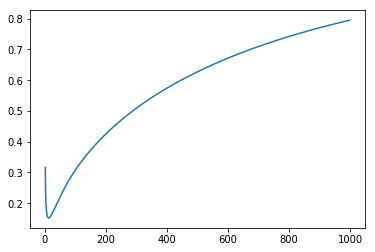

In [19]:
def beta_part(n):
    beta1 = 0.9
    beta2 = 0.999
    
    return np.sqrt(1-beta2**n) / (1 - beta1**n)
    
n = np.arange(1, 1000)
plt.plot(n, beta_part(n), '-')

As you can see, the proportion increases with iterations. As a better gradient average is collected, and the solution is starting to be found, the 'learning rate' is increased, and it starts to use the full gradients, which SGD does right off the bat (which explains its jumping around). 

In [20]:
grad_trace = 0
grad_squared_trace = 0
update_step = 0

def adam_init():
    global grad_trace, grad_squared_trace, update_step

    grad_trace = 0
    grad_squared_trace = 0
    update_step = 0
    
def adam(w, w_views, X1, T, learning_rate):
    global grad_trace, grad_squared_trace, update_step

    beta1 = 0.9
    beta2 = 0.999
    epsilon = 1e-8

    Z1, Y = forward(w_views, X1)

    # Error in output
    error = T - Y

    gradient = backward(w_views, X1, Z1, T, error)
    
    # approximate first and second moment
    grad_trace = beta1 * grad_trace + (1 - beta1) * gradient
    grad_squared_trace = beta2 * grad_squared_trace + (1 - beta2) * np.square(gradient)
    
    # bias corrected moment estimates
    grad_hat = grad_trace / (1 - beta1 ** (update_step + 1) )
    grad_squared_hat = grad_squared_trace / (1 - beta2 ** (update_step + 1) )
                
    dw = grad_hat / (np.sqrt(grad_squared_hat) + epsilon)
    
    n_samples = X1.shape[0]
    n_outputs = T.shape[1]
    
    # update values of w, in place. Don't need to return it.
    w -= learning_rate / (n_samples + n_outputs) * dw
    
    update_step += 1

Now, we put our model and a means of training it with adam or sgd into a single function. It will update the weights using adam or sgd. It will iterate through the data `n_epochs` number of times. It will train the model using batches of the data, and the number of samples in these batches is specified by `batch_size`. 

In [21]:
def train(Xtrain, Ttrain, Xtest, Ttest,
          n_hiddens, 
          gradient_descent_method_init, gradient_descent_method, 
          batch_size, n_epochs, learning_rate, graphics_rate=0):

    if graphics_rate > 0 and Xtrain.shape[1] > 1:
        print('Graphics only works when X has one column (data has one input variable)')
        print('Setting graphics_rate to 0')
        graphics_rate = 0
    
    # Initialize weights to uniformly distributed values between small normally-distributed between -0.1 and 0.1
    n_inputs = Xtrain.shape[1]
    n_outputs = Ttrain.shape[1]
    Vshape = (1 + n_inputs, n_hiddens)
    Wshape = (1 + n_hiddens, n_outputs)
    w, [V, W] = make_weights([Vshape, Wshape])

    error_trace = np.zeros((n_epochs, 2))

    if graphics_rate > 0:
        fig = plt.figure(figsize=(12, 10))
        
    Xtrain1 = np.insert(Xtrain, 0, 1, 1)
    Xtest1 = np.insert(Xtest, 0, 1, 1)
    n_samples = Xtrain1.shape[0]
        
    gradient_descent_method_init()
    
    for epoch in range(n_epochs):

        # gradient_descent_method_init()
        
        # Reorder samples
        rows = np.arange(n_samples)
        np.random.shuffle(rows)
        
        for first_n in range(0, n_samples, batch_size):
            last_n = first_n + batch_size
            rows_batch = rows[first_n:last_n]
            Xtrain1_batch = Xtrain1[rows_batch, :]
            Ttrain_batch = Ttrain[rows_batch, :]
            # gradient_descent method changes values of w
            gradient_descent_method(w, [V, W], Xtrain1_batch, Ttrain_batch, learning_rate)
    
        # error traces for plotting
        Z1train, Ytrain = forward([V, W], Xtrain1)
        error_trace[epoch, 0] = np.sqrt(np.mean(((Ttrain - Ytrain)**2)))
    
        Z1test, Ytest = forward([V, W], Xtest1)
        error_trace[epoch, 1] = np.sqrt(np.mean((Ytest - Ttest)**2))

        if graphics_rate > 0 and (epoch % graphics_rate == 0 or epoch == n_epochs - 1):
            plt.clf()
            plt.subplot(3, 1, 1)
            plt.plot(error_trace[:epoch, :])
            plt.ylim(0, 0.4)
            plt.xlabel('Epoch')
            plt.ylabel('RMSE')
            plt.legend(('Train','Test'), loc='upper left')
        
            plt.subplot(3, 1, 2)
            plt.plot(Xtrain, Ttrain, 'o-', Xtest, Ttest, 'o-', Xtrain, Ytrain, 'o-')
            plt.xlim(-1, 1)
            plt.ylim(-0.2, 1.6)
            plt.legend(('Training', 'Testing', 'Model'), loc='upper left')
            plt.xlabel('$x$')
            plt.ylabel('Actual and Predicted $f(x)$')
        
            plt.subplot(3, 1, 3)
            plt.plot(Xtrain, Z1train[:, 1:])  # Don't plot the constant 1 column
            plt.ylim(-1.1, 1.1)
            plt.xlabel('$x$')
            plt.ylabel('Hidden Unit Outputs ($z$)');
        
            ipd.clear_output(wait=True)
            ipd.display(fig)

    ipd.clear_output(wait=True)

    return Ytrain, Ytest, error_trace

Here are some demonstrations.

In [22]:
# Make some training data
n = 20
Xtrain = np.linspace(0.,20.0,n).reshape((n,1)) - 10
Ttrain = 0.2 + 0.05 * (Xtrain + 10) + 0.4 * np.sin(Xtrain + 10) + 0.2 * np.sin(Xtrain * 3) + 0.01 * np.random.normal(size=(n, 1))
Xtrain = Xtrain / 10

# Make some testing data
n = n // 3
Xtest = np.linspace(0, 20, n).reshape((-1, 1)) - 10
Ttest = 0.2 + 0.05 * (Xtest + 10) + 0.2 * np.sin(Xtest + 10) +  0.1 * np.sin(Xtest * 3) + 0.01 * np.random.normal(size=(n, 1))
Xtest = Xtest / 10

Final RMSE 0.14274699253707848


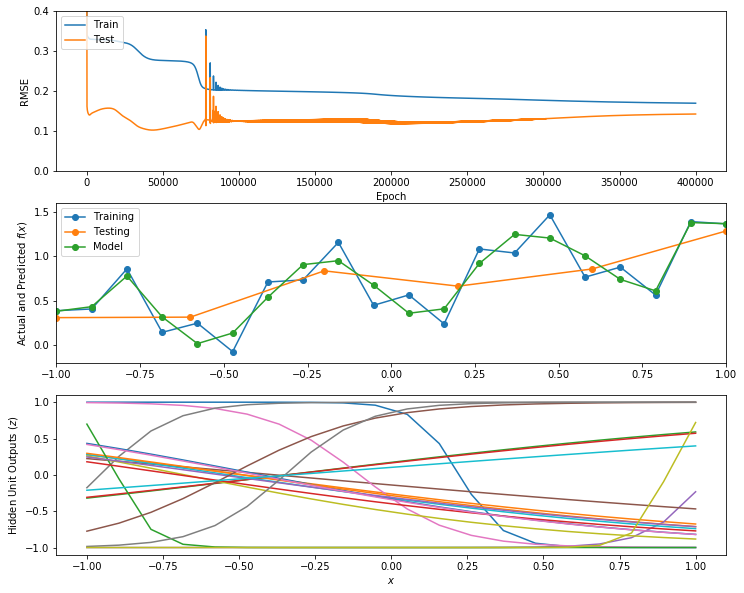

In [23]:
Ytrain, Ytest, error_trace = train(Xtrain, Ttrain, Xtest, Ttest, n_hiddens=20, 
                       gradient_descent_method_init=sgd_init, gradient_descent_method=sgd,
                       batch_size=Xtrain.shape[0], n_epochs=400000, learning_rate=0.2, graphics_rate=10000)
print('Final RMSE', np.sqrt(np.mean((Ttest - Ytest)**2)))

Notice that the training doesn't hit zero RMSE. Because SGD converges to the nearest local minimum, it can't find the best solution even after 400,000 epochs. It's also worth pointing out that the testing curb did start to increase meaning it has begun over fitting. It's best Testing RMSE seems to be slightly above .1 around 50,000 iterations.

Final RMSE 0.24669154465845752


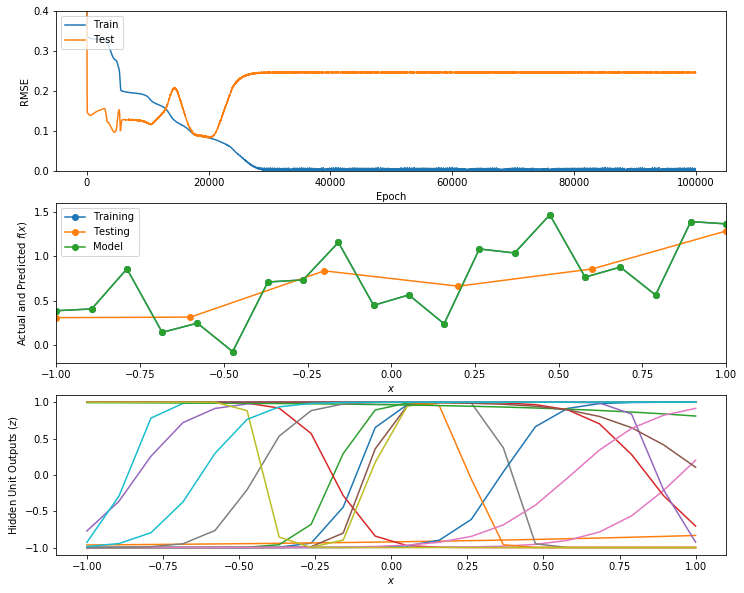

In [24]:
Ytrain, Ytest, error_trace = train(Xtrain, Ttrain, Xtest, Ttest, n_hiddens=20, 
                       gradient_descent_method_init=adam_init, gradient_descent_method=adam,
                       batch_size=Xtrain.shape[0], n_epochs=100000, learning_rate=0.05, graphics_rate=5000)
print('Final RMSE', np.sqrt(np.mean((Ttest - Ytest)**2)))

For Adam, it does a really good job of finding a global minimum and doing so very quickly. It finds the .1 testing minimum at 20,000 iterations, much faster than SGD. It's final RMSE was higher, but that's due to poor training methods. Adam clearly performs much better. 

SGD 0.14614088962399563 Adam 0.18948901312524752


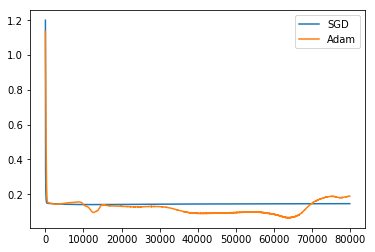

In [28]:
n_samples = Xtrain.shape[0]

_, _, error_trace_adam = train(Xtrain, Ttrain, Xtest, Ttest, n_hiddens=20, 
                       gradient_descent_method_init=adam_init, gradient_descent_method=adam,
                       batch_size=n_samples, n_epochs=80000, learning_rate=0.01, graphics_rate=0)

_, _, error_trace_sgd = train(Xtrain, Ttrain, Xtest, Ttest, n_hiddens=20, 
                       gradient_descent_method_init=sgd_init, gradient_descent_method=sgd,
                       batch_size=n_samples, n_epochs=80000, learning_rate=0.01, graphics_rate=0)

plt.plot(np.hstack((error_trace_sgd[:, 1:], error_trace_adam[:, 1:])))
plt.legend(('SGD', 'Adam'))

print('SGD', error_trace_sgd[-1, 1], 'Adam', error_trace_adam[-1, 1])

The curbs look the same, but Adam has some wavering around 10,000 where it raises above and then drops below SGD. This is the plot for testing RMSE, and multiple runs generally show the same behavior. That means initially SGD outperforms Adam, but then Adam outperforms SGD. I wonder if this is because SGD and Adam both converge to the nearest local minimum, but SGD does so quicker since it's using the local gradient. Since adam uses multiple gradients, it doesn't converge to it as quick, but it does pass by it to find the better solution, hence the smaller testing RMSE dip. 

I wonder if using SGD at first would breat the momentum component of Adam. If not, we could use SGD as a bootstrapping technique. 

I changed epochs to 40,000 since I wanted to see if adam would over fit. Surprisingly it didn't until I changed the number of epochs to 80,000. It finds a better testing weights, but then with too much training it performs worse than SGD's local solution.

# Search for Good Parameter Values on a New Data Set

In [46]:
import itertools
import pandas as pd

In [47]:
def split_data(X, T, ratio=.8):
    """X is the data, and T is the labels. ratio is the proportion to be training data.
    
    Usage:
        Xtrain, Xtest, Ttrain, Ttest = split_data(X, T, ratio=.75)
    """
    num_points = X.shape[0]
    num_train = int(X.shape[0]*ratio)
    return X[:num_train], X[num_train:], T[:num_train], T[num_train:]

In [48]:
split_dataX = np.arange(10*30).reshape(10, -1)
for part in split_data(split_dataX[:, :-1], split_dataX[:, -1:]):
    print(part.shape)

(8, 29)
(2, 29)
(8, 1)
(2, 1)


The training sets have 8 rows and the testing sets have 2, as expected.

In [49]:
def get_standardize(A):
    return np.mean(A, axis=0), np.std(A, axis=0)

def standardize(A, normalizer=None):
    if normalizer is None:
        normalizer = get_standardize(A)
    mean, std = normalizer
    return (A-mean)/std, normalizer

def unstandardize(A, normalizer):
    mean, std = normalizer
    return mean + A * std

If I standardize the standardized matrix, then there should be a mean of means of 0, and mean of std devs of 1.

In [50]:
a = np.arange(30)[:, None]*np.random.rand(30, 40).reshape(30, -1)
print(a.shape)
np.set_printoptions(precision=2)
print(np.mean(get_standardize(standardize(a)[0]), axis=1))
data_reconstructed = unstandardize(*standardize(data))
reconstructed_was_close = np.all(np.isclose(data, data_reconstructed))
print('Data is same as standardized and then unstandardized:', reconstructed_was_close)

(30, 40)
[-3.9e-17  1.0e+00]
Data is same as standardized and then unstandardized: True


Good!

In [51]:
def rmse(Y, T):
    return np.sqrt(np.mean((T - Y)**2))

In [52]:
data = pd.read_excel('Real_estate_valuation_data_set.xlsx').drop('No', axis=1)
print('Labels:', data.columns.tolist())
datanp = np.array(data)
np.random.shuffle(datanp)
X = datanp[:, :-1]
T = datanp[:, -1:]
print('X and T shapes:', X.shape, T.shape)
Xtrain, Xtest, Ttrain, Ttest = split_data(X, T)
print('Train and test split shapes:', Xtrain.shape, Xtest.shape, Ttrain.shape, Ttest.shape)

Labels: ['X1 transaction date', 'X2 house age', 'X3 distance to the nearest MRT station', 'X4 number of convenience stores', 'X5 latitude', 'X6 longitude', 'Y house price of unit area']
X and T shapes: (414, 6) (414, 1)
Train and test split shapes: (331, 6) (83, 6) (331, 1) (83, 1)


Now, to normalize the data, we can't use the test data to normalize since that gives the model information about the data.

In [53]:
Xtrain_std, Xnormer = standardize(Xtrain)
Xtest_std, _ = standardize(Xtest, Xnormer)
Ttrain_std, Tnormer = standardize(Ttrain)
Ttest_std, _ = standardize(Ttest, Tnormer)

In [54]:
def run_param(Xtrain, Ttrain, Xtest, Ttest, algorithm, n_epochs, learning_rate, n_hiddens, batch_size):
    # prep args
    if algorithm == 'adam':
        algo_args = {'gradient_descent_method_init': adam_init,
                     'gradient_descent_method': adam}
    elif algorithm == 'sgd':
        algo_args = {'gradient_descent_method_init': sgd_init,
                    'gradient_descent_method': sgd}
    else:
        algo_args = None  # cause exception on misuse
    
    # run
    Ytrain, Ytest, error_trace_sgd = train(Xtrain, Ttrain, Xtest, Ttest, 
                                  n_hiddens=n_hiddens, batch_size=batch_size, 
                                  n_epochs=n_epochs, learning_rate=learning_rate, 
                                  **algo_args, graphics_rate=0)
    rmse_train = rmse(Ytrain, Ttrain)
    rmse_test = rmse(Ytest, Ttest)

    return [algorithm, n_epochs, learning_rate, n_hiddens, batch_size, rmse_train, rmse_test]

def run_parameters(Xtrain, Ttrain, Xtest, Ttest, n_epochs, learning_rate, n_hiddens, batch_size, verbose):
    algorithms = ['sgd', 'adam']
    params = [algorithms, n_epochs, learning_rate, n_hiddens, batch_size]
    param_space = itertools.product(*params)
    param_space_len = 1
    for param in params:
        param_space_len *= len(param)
    header = ['Algorithm', 'Epochs', 'Learning Rate', 'Hidden Units', 'Batch Size', 
                'RMSE Train', 'RMSE Test']
    results = pd.DataFrame(columns=header)
    if verbose:
        print(header)
    for i, param in enumerate(param_space):
        result = run_param(Xtrain, Ttrain, Xtest, Ttest, *param)
        if verbose:
            print('{}/{}: {}'.format(i+1, param_space_len, result))
        results.loc[len(results)] = result
    return results

In [58]:
n_epochs = [1, 10, 100, 1000]
learning_rate = [1.0, 0.1, 0.01, 0.001]
n_hiddens = [5, 10, 25, 50]
batch_size = [5, 10, 1000]
verbose = True
results = run_parameters(Xtrain_std, Ttrain, Xtest_std, Ttest, n_epochs, learning_rate, n_hiddens, batch_size, verbose)
results.sort_values('RMSE Test').head(50)

384/384: ['adam', 1000, 0.001, 50, 1000, 40.411365385856776, 40.00469981923403]


,Algorithm,Epochs,Learning Rate,Hidden Units,Batch Size,RMSE Train,RMSE Test
349,adam,1000,0.100,5,10,7.205295,6.939922
304,adam,100,0.100,10,10,7.618274,6.993656
176,sgd,1000,0.010,25,1000,6.956921,7.026575
135,sgd,100,0.001,10,5,7.303303,7.047693
307,adam,100,0.100,25,10,6.997373,7.085340
78,sgd,10,0.010,25,5,7.396483,7.129052
138,sgd,100,0.001,25,5,7.282081,7.144252
141,sgd,100,0.001,50,5,7.221914,7.167693
184,sgd,1000,0.001,10,10,6.536970,7.182093
261,adam,10,0.100,50,5,7.838680,7.182413


It looks like Adam really likes having a larger learning rate while sgd likes is much smaller. The hidden layers for the best performing was small too, along with batch size. The best SGD uses more layers, a much larger batch size, and a smaller learning rate. The second best SGD shows it can perform with small batches and fewer hidden layers; however, it still has a really small learning rate and requires a lot of epochs.

Params: ['adam', 1000, 0.1, 5, 10]
Params: ['sgd', 1000, 0.01, 25, 1000]
SGD 7.022353354590321 Adam 7.806830728119557


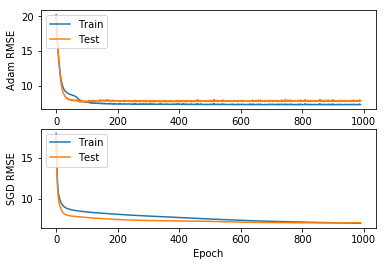

In [104]:
top_res = np.array(results.sort_values('RMSE Test').head(50))
print(top_res[top_res[:, 0]=='adam'][0])
*params_a, _, _ = top_res[top_res[:, 0]=='adam'][0]
*params_s, _, _ = top_res[top_res[:, 0]=='sgd'][0]

n_epochs_a, lr_a, units_a, bs_a = params_a[1:]
n_epochs_s, lr_s, units_s, bs_s = params_s[1:]


_, _, error_trace_adam = train(Xtrain_std, Ttrain, Xtest_std, Ttest, n_hiddens=units_a, 
                       gradient_descent_method_init=adam_init, gradient_descent_method=adam,
                       batch_size=bs_a, n_epochs=n_epochs_a, learning_rate=lr_a, graphics_rate=0)

_, _, error_trace_sgd = train(Xtrain_std, Ttrain, Xtest_std, Ttest, n_hiddens=units_s, 
                       gradient_descent_method_init=sgd_init, gradient_descent_method=sgd,
                       batch_size=bs_s, n_epochs=n_epochs_s, learning_rate=lr_s, graphics_rate=0)

plt.subplot(2, 1, 1)
plt.plot(error_trace_adam[10:])
#plt.ylim(5, 7)
plt.xlabel('Epoch')
plt.ylabel('Adam RMSE')
plt.legend(('Train','Test'), loc='upper left')

plt.subplot(2, 1, 2)
plt.plot(error_trace_sgd[10:])
#plt.ylim(5, 7)
plt.xlabel('Epoch')
plt.ylabel('SGD RMSE')
plt.legend(('Train','Test'), loc='upper left')


print('Params:', params_a)
print('Params:', params_s)
print('SGD', error_trace_sgd[-1, 1], 'Adam', error_trace_adam[-1, 1])

I don't know why, but adam seems to perform worse. It looks like testing is rising again after 600. I don't have that in my grid search, so that's probably why it chooses 1000 over 100 even though 600 is the better choice.

It still does perform in the 6.0-8.0 testing RMSE range, so it does perform fairly well it seems.

It's also good that it's clearly not overfitting. It seems to have found a place where the blue and orange intersect but it stops before testing RMSE can rise too much (especially for SGD, which is why I think it performs better).

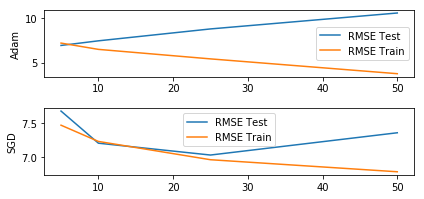

In [125]:
nhadam =results.loc[(results['Algorithm'] == 'adam') & (results['Epochs'] == n_epochs_a) &
                    (results['Learning Rate'] == lr_a) & (results['Batch Size'] == bs_a)]
nhsgd=results.loc[(results['Algorithm'] == 'sgd') & (results['Epochs'] == n_epochs_s) &
                    (results['Learning Rate'] == lr_s) & (results['Batch Size'] == bs_s)]


plt.subplot(311)
plt.ylabel('Adam')
plt.plot(nhadam['Hidden Units'], nhadam['RMSE Test'], label='RMSE Test')
plt.plot(nhadam['Hidden Units'], nhadam['RMSE Train'], label='RMSE Train')
plt.legend()
plt.subplot(312)
plt.ylabel('SGD')
plt.plot(nhsgd['Hidden Units'], nhsgd['RMSE Test'], label='RMSE Test')
plt.plot(nhsgd['Hidden Units'], nhsgd['RMSE Train'], label='RMSE Train')
plt.legend()
plt.tight_layout()

For Adam, a small number of hidden layers is sufficient in capturing the complexity of the system. That's why training RMSE lowers, but testing RMSE rises. It starts to over fit.

For SGD, it performs better with more than Adam. 15-20 seems to be the best. Any more, it gains the ability to over fit.

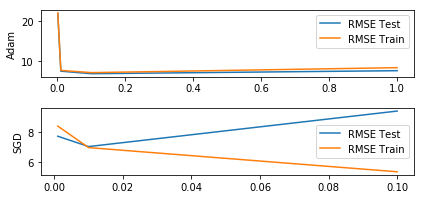

In [126]:
lradam =results.loc[(results['Algorithm'] == 'adam') & (results['Epochs'] == n_epochs_a) &
                    (results['Hidden Units'] == units_a) & (results['Batch Size'] == bs_a)]
lrsgd=results.loc[(results['Algorithm'] == 'sgd') & (results['Epochs'] == n_epochs_s) &
                    (results['Hidden Units'] == units_s) & (results['Batch Size'] == bs_s)]

plt.subplot(311)
plt.ylabel('Adam')
plt.plot(lradam['Learning Rate'], lradam['RMSE Test'], label='RMSE Test')
plt.plot(lradam['Learning Rate'], lradam['RMSE Train'], label='RMSE Train')
plt.legend()
plt.subplot(312)
plt.ylabel('SGD')
plt.plot(lrsgd['Learning Rate'], lrsgd['RMSE Test'], label='RMSE Test')
plt.plot(lrsgd['Learning Rate'], lrsgd['RMSE Train'], label='RMSE Train')
plt.legend()
plt.tight_layout()

Adam seems to not really care about the learning rate (except for it can't be super small). Testing and training are pretty similar. SGD fails when it's higher.

## Grading

Download [A2grader.tar](http://www.cs.colostate.edu/~anderson/cs445/notebooks/A2grader.tar) and extract `A2grader.py` from it. Run the code in the following cell to demonstrate an example grading session.  You should see a perfect execution score of 90 out of 90 points if your functions are defined correctly. The remaining 10 points will be based on the results you obtain from the energy data and on your discussions.

For the grading script to run correctly, you must first name this notebook as 'Lastname-A2.ipynb' with 'Lastname' being your last name, and then save this notebook.

A different, but similar, grading script will be used to grade your checked-in notebook.  It will include additional tests.  You need not include code to test that the values passed in to your functions are the correct form.

In [127]:
%run -i A2grader.py

,Algorithm,Epochs,Learning Rate,Hidden Units,Batch Size,RMSE Train,RMSE Test
0,sgd,10,0.001,5,1,107.954595,182.266300
1,sgd,10,0.001,5,50,165.357376,238.225207
2,sgd,10,0.001,10,1,96.450471,179.422270
3,sgd,10,0.001,10,50,158.925278,232.179085
4,sgd,10,0.010,5,1,100.576395,163.066902
5,sgd,10,0.010,5,50,126.704799,201.748703
6,sgd,10,0.010,10,1,96.719187,174.412656
7,sgd,10,0.010,10,50,111.499879,194.071880
8,sgd,100,0.001,5,1,92.704554,178.776424
9,sgd,100,0.001,5,50,124.109621,198.382509




--- 40/40 points. run_parameters terminates.

--- 20/20 points. results.shape is correct.

--- 10/10 points. results column names is correct.

--- 10/10 points. Values in results Algorithm column correct.

--- 10/10 points. Number of epochs for lowest RMSE Train is correct.

a2 Execution Grade is 90 / 90

 Remaining 10 points will be based on your text descriptions of results and plots.

a2 FINAL GRADE is   / 100

a2 EXTRA CREDIT is   / 1


<Figure size 432x288 with 0 Axes>

# Extra Credit

Didn't do it :(